In [1]:
from project_helper import TweetData, IntradayData, FuturesCloseData
import pandas as pd
import numpy as np
from pytz import timezone
import datetime
from datetime import timedelta  
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Intraday S&P500 futures features

This notebook creates features derived from Trump's tweets, where we observe short term returns in S&P500 futures after each tweet. We look at 1 minute, 5 minute, and 15 minute returns after every tweet

A project from this class, two years ago, found that 5 minute returns was the most predictive out of short term returns: https://pdfs.semanticscholar.org/af67/ae4c3ac357679c10ddc394df52d392432f63.pdf. 

It's normal to see an overreaction to a tweet the market thinks relevant, and then see a portion of the move fade. Instead of focusing on the most predictive return, we will look at the difference between 15 minute returns and 5 minute returns, as well as an average of 1, 5, and 15 mnute returns. 

From here we have three features: 

- **intra_ret_1**: The 1 minute return for the tweet with the largest absolute 1 minute return for the day
- **intra_ret_5**: The 5 minute return for the tweet with the largest absolute 5 minute return for the day
- **intra_ret_15**: The 15 minute return for the tweet with the largest absolute 15 minute return for the day
- **intra_blend**: Average of the last 3 features
- **intra_diff_15_5**: Difference between 15 minute and 5 minute return, same tweet used for intra_ret_5. If it's positive, the move kept going in the same direction of the 5 minute return, if negative, the move faded.

In [2]:
tweet_data = TweetData()
tweet_data.raw_tweets.head()

,tweets
timestamp,
2019-11-17 19:57:12-06:00,"""Tell Jennifer Williams whoever that is to rea..."
2019-11-17 19:56:02-06:00,"""https://t.co/I3lO117SVh"
2019-11-17 19:49:47-06:00,"""Paul Krugman of @nytimes has been wrong about..."
2019-11-17 19:47:32-06:00,"""Schiff is a Corrupt Politician! https://t.co/..."
2019-11-17 19:30:09-06:00,""".@SteveScalise blew the nasty &amp; obnoxious..."


In [3]:
md = IntradayData()
fin_data = md.get_data()

In [4]:
# Number of tweets with exactly the same timestamp
len(tweet_data.raw_tweets.index) - len(set(tweet_data.raw_tweets.index))

321

In [5]:
print(fin_data.shape)
fin_data.head()

(1040156, 2)


,Open,Close
timestamp,,
2016-11-13 17:01:00-06:00,2183.00,2183.25
2016-11-13 17:02:00-06:00,2183.25,2182.00
2016-11-13 17:03:00-06:00,2182.00,2182.75
2016-11-13 17:04:00-06:00,2182.50,2182.50
2016-11-13 17:05:00-06:00,2182.75,2183.00


In [6]:
subset = (tweet_data.raw_tweets.index > fin_data.index[0]) & (tweet_data.raw_tweets.index < fin_data.index[-1])
sub_data = tweet_data.raw_tweets[subset]

In [7]:
sub_data.head()

,tweets
timestamp,
2019-11-08 03:08:53-06:00,"""https://t.co/z0I7wBsgTP"
2019-11-08 00:08:15-06:00,"""STATEMENT FROM PRESIDENT DONALD J. TRUMP http..."
2019-11-07 15:43:29-06:00,"""Stock Market up big today. A New Record. Enjoy!"
2019-11-07 15:41:53-06:00,"""The Radical Left Dems and LameStream Media ar..."
2019-11-07 15:27:57-06:00,"""The Amazon Washington Post and three lowlife ..."


In [8]:
ts_pre = [ time + datetime.timedelta(seconds = - time.second) for i, time in enumerate(sub_data.index)]
ts_post = [ time + datetime.timedelta(seconds = 60*1 - time.second) for i, time in enumerate(sub_data.index)]
ts_1min = [ time + datetime.timedelta(seconds = 60*2 - time.second) for i, time in enumerate(sub_data.index)]
ts_5min = [ time + datetime.timedelta(seconds = 60*6 - time.second) for i, time in enumerate(sub_data.index)]
ts_15min = [ time + datetime.timedelta(seconds = 60*16 - time.second) for i, time in enumerate(sub_data.index)]

In [9]:
min_dict = {}
for i, ts in enumerate(ts_post):
    try:
        min_dict[ts] = min_dict[ts] + sub_data.tweets.iloc[i]
    except KeyError:
        min_dict[ts] = sub_data.tweets.iloc[i]
        
data_min = pd.DataFrame(data = min_dict.values(), index = min_dict.keys())
data_min.columns = ['tweets']
data_min.index.name = 'timestamp'
data_min.head()

,tweets
timestamp,
2019-11-08 03:09:00-06:00,"""https://t.co/z0I7wBsgTP"
2019-11-08 00:09:00-06:00,"""STATEMENT FROM PRESIDENT DONALD J. TRUMP http..."
2019-11-07 15:44:00-06:00,"""Stock Market up big today. A New Record. Enjoy!"
2019-11-07 15:42:00-06:00,"""The Radical Left Dems and LameStream Media ar..."
2019-11-07 15:28:00-06:00,"""The Amazon Washington Post and three lowlife ..."


In [10]:
ts_dict = {a:b for a, b in zip(ts_post, sub_data.index)}

In [11]:
for ret, ts in zip(['ret_1', 'ret_5', 'ret_15'],[ts_1min,ts_5min,ts_15min] ):
    imp_open = fin_data.loc[ts_post]['Open']
    imp_close = fin_data.loc[ts]['Close']
    hl = (imp_open - imp_close.values)/imp_open
    hl = hl.loc[~hl.index.duplicated(keep='first')]
    data_min[ret] = hl.values
    
data_min = data_min.dropna()

In [12]:
data_min.head()

,tweets,ret_1,ret_5,ret_15
timestamp,,,,
2019-11-08 03:09:00-06:00,"""https://t.co/z0I7wBsgTP",0.000162,0.000406,0.000406
2019-11-08 00:09:00-06:00,"""STATEMENT FROM PRESIDENT DONALD J. TRUMP http...",0.000162,0.000244,0.000244
2019-11-07 15:44:00-06:00,"""Stock Market up big today. A New Record. Enjoy!",-0.000081,0.000000,0.000000
2019-11-07 15:42:00-06:00,"""The Radical Left Dems and LameStream Media ar...",0.000000,0.000000,0.000000
2019-11-07 14:52:00-06:00,"""What did Hunter Biden do for the money? @SenJ...",0.000730,0.000730,-0.000081


In [13]:
after_4_tweets = data_min.index.hour >= 15
data_min['after4_date'] = data_min.index
data_min.after4_date[after_4_tweets] +=  timedelta(days=1)
data_min.after4_date =data_min.after4_date.dt.date

/Users/lalopey/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Difference between 15 minute and 5 minute return, same tweet used for intra_ret_5. If it's positive, the move kept going in the same direction of the 5 minute return, if negative, the move faded.

In [113]:
mini = data_min.groupby('after4_date').min()
mini_15 = data_min.loc[data_min.groupby('after4_date').idxmin().ret_5][['ret_15','after4_date']]
mini_15 = mini_15.set_index('after4_date')
mini['diff_15_5'] = mini_15 
# notice different sides for the diff_15_5 in mini and maxi calculations
mini['diff_15_5'] = mini['ret_5'] - mini['diff_15_5']  
maxi = data_min.groupby('after4_date').max()
maxi_15 = data_min.loc[data_min.groupby('after4_date').idxmax().ret_5][['ret_15','after4_date']]
maxi_15 = maxi_15.set_index('after4_date')
maxi['diff_15_5'] = maxi_15 
maxi['diff_15_5'] = maxi['diff_15_5'] - maxi['ret_5']
features = pd.DataFrame(index = mini.index, columns=['intra_ret_1', 'intra_ret_5', 'intra_ret_15', 'intra_diff_15_5'] )

In [135]:
maxi.head()

,tweets,ret_1,ret_5,ret_15,diff_15_5
after4_date,,,,,
2016-11-14,"""The debates especially the second and third p...",-0.000114,-0.000343,-0.000685,-0.000343
2016-11-15,"""The Electoral College is actually genius in t...",0.000000,-0.000456,-0.000685,-0.000684
2016-11-16,"""Very organized process taking place as I deci...",0.000228,0.000683,0.000455,-0.000228
2016-11-17,"""My transition team which is working long hour...",-0.000114,-0.000114,0.000795,0.000908
2016-11-18,"""Just got a call from my friend Bill Ford Chai...",0.000454,0.001022,0.000908,-0.000114


In [121]:
for ind in mini.index: 
    for ret in ['ret_1', 'ret_5', 'ret_15']:
        if abs(mini[ret].loc[ind]) > abs(maxi[ret].loc[ind]):
            features['intra_' + ret].loc[ind] = mini[ret].loc[ind]
            if ret == 'ret_5':
                features['intra_diff_15_5'].loc[ind] = mini['diff_15_5'].loc[ind]
        else:
            features['intra_' + ret].loc[ind] = maxi['diff_15_5'].loc[ind]
            if ret == 'ret_5':
                features['intra_diff_15_5'].loc[ind] = maxi['diff_15_5'].loc[ind]
            

In [136]:
features.head()

,intra_ret_1,intra_ret_5,intra_ret_15,intra_diff_15_5,intra_blend
timestamp,,,,,
2016-11-14,-0.00034274,-0.00034274,-0.00034274,-0.00034274,-0.000343
2016-11-15,-0.000114129,-0.000570646,-0.00114064,0.000114129,-0.000418
2016-11-16,-0.000456934,-0.000227635,-0.000799543,-0.000227635,-0.000304
2016-11-17,0.000908265,0.000908265,0.000908265,0.000908265,0.000908
2016-11-18,-0.00011352,-0.00011352,-0.00011352,-0.00011352,-0.000114


In [139]:
features.index.name = 'date'
features['intra_blend'] = features[['intra_ret_1','intra_ret_5','intra_ret_5' ]].mean(axis=1)
features.to_csv('features/intra_sp_features.csv')

In [138]:
features

,intra_ret_1,intra_ret_5,intra_ret_15,intra_diff_15_5,intra_blend
date,,,,,
2016-11-14,-0.00034274,-0.00034274,-0.00034274,-0.00034274,-0.000343
2016-11-15,-0.000114129,-0.000570646,-0.00114064,0.000114129,-0.000418
2016-11-16,-0.000456934,-0.000227635,-0.000799543,-0.000227635,-0.000304
2016-11-17,0.000908265,0.000908265,0.000908265,0.000908265,0.000908
2016-11-18,-0.00011352,-0.00011352,-0.00011352,-0.00011352,-0.000114
...,...,...,...,...,...
2019-11-04,-0.000568921,-0.000406108,-8.14266e-05,-0.000162443,-0.000460
2019-11-05,-0.000405383,-0.000569152,-0.000405383,-0.000162615,-0.000515
2019-11-06,8.13736e-05,8.13736e-05,8.13736e-05,8.13736e-05,0.000081


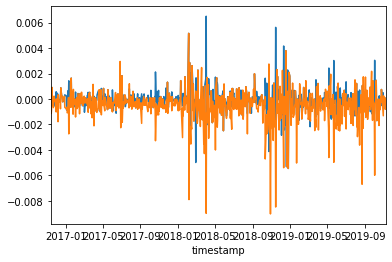

In [133]:
features['intra_diff_15_5'].plot()
features['intra_ret_15'].plot()

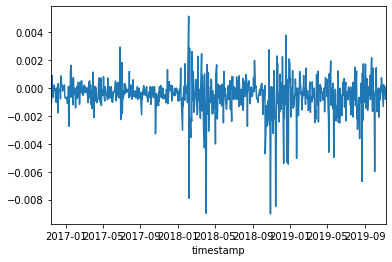

In [131]:
features['intra_ret_15'].plot()

In [ ]:
features['intra_r'].plot()

In [129]:
data_min

,tweets,ret_1,ret_5,ret_15,after4_date
timestamp,,,,,
2019-11-08 03:09:00-06:00,"""https://t.co/z0I7wBsgTP",0.000162,0.000406,0.000406,2019-11-08
2019-11-08 00:09:00-06:00,"""STATEMENT FROM PRESIDENT DONALD J. TRUMP http...",0.000162,0.000244,0.000244,2019-11-08
2019-11-07 15:44:00-06:00,"""Stock Market up big today. A New Record. Enjoy!",-0.000081,0.000000,0.000000,2019-11-08
2019-11-07 15:42:00-06:00,"""The Radical Left Dems and LameStream Media ar...",0.000000,0.000000,0.000000,2019-11-08
2019-11-07 14:52:00-06:00,"""What did Hunter Biden do for the money? @SenJ...",0.000730,0.000730,-0.000081,2019-11-07
...,...,...,...,...,...
2016-11-16 11:29:00-06:00,"""I am not trying to get """"top level security c...",-0.000114,-0.000571,-0.000114,2016-11-16
2016-11-16 02:56:00-06:00,"""Very organized process taking place as I deci...",0.000228,0.000683,0.000455,2016-11-16
2016-11-15 13:41:00-06:00,"""The Electoral College is actually genius in t...",0.000000,-0.000456,-0.001141,2016-11-15


In [126]:
data_min_sort = data_min.dropna().sort_values(by = 'ret_5')
print(data_min_sort.shape)
data_min_sort.head()

(5923, 5)


,tweets,ret_1,ret_5,ret_15,after4_date
timestamp,,,,,
2019-08-23 14:58:00-05:00,"""As usual the Fed did NOTHING! It is incredibl...",-0.001938,-0.007930,-0.006696,2019-08-23
2019-08-23 15:00:00-05:00,"""....all deliveries of Fentanyl from China (or...",-0.003253,-0.006331,-0.005276,2019-08-24
2018-12-07 11:54:00-06:00,"""....Foundation be listed at the top of the Re...",-0.002064,-0.003846,-0.002626,2018-12-07
2018-12-21 14:42:00-06:00,"""There has never been a president who has been...",-0.001752,-0.003608,-0.002165,2018-12-21
2018-12-19 14:45:00-06:00,"""The Trump Foundation has done great work and ...",-0.001790,-0.003580,-0.001690,2018-12-19


In [127]:
data_min_sort.to_csv('results/sorted_trump.csv')

In [128]:
tweet_data.clean_tweets

,tweets,timestamp,after4_date
timestamp,,,
2019-11-17 19:57:12-06:00,tell jennifer williams whoever that is to read...,2019-11-17 19:57:12-06:00,2019-11-18
2019-11-17 19:56:02-06:00,,2019-11-17 19:56:02-06:00,2019-11-18
2019-11-17 19:49:47-06:00,paul krugman of has been wrong about me from t...,2019-11-17 19:49:47-06:00,2019-11-18
2019-11-17 19:47:32-06:00,schiff is a corrupt politician,2019-11-17 19:47:32-06:00,2019-11-18
2019-11-17 19:30:09-06:00,blew the nasty amp obnoxious chris wallace wil...,2019-11-17 19:30:09-06:00,2019-11-18
...,...,...,...
2009-05-12 14:07:28-05:00,my persona will never be that of a wallflower ...,2009-05-12 14:07:28-05:00,2009-05-12
2009-05-08 20:40:15-05:00,new blog post celebrity apprentice finale and ...,2009-05-08 20:40:15-05:00,2009-05-09
2009-05-08 13:38:08-05:00,donald trump reads top ten financial tips on l...,2009-05-08 13:38:08-05:00,2009-05-08
